In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)
figfolder = os.path.join(root, 'Analysis','figures')

In [3]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [4]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
print(save_filename)
print(time.ctime(os.path.getmtime(save_filename)))
dec = np.load(save_filename, allow_pickle=True).item()
dec.keys()
roi_names = dec['roi_names']
n_rois = len(roi_names)

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_binary_withintask.npy
Wed Aug 14 23:11:22 2024


In [6]:
dec['acc_bytask'].shape

(10, 8, 4, 3)

#### Get accuracy of the "nonlinear" boundary classifier.

In [7]:
n_tasks = 3

acc_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

acc_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 1))

ii = 0;

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        dist = l['dist_from_bound3'].round(2)
        
        categ_actual = np.array(l['categ_task3']).astype(int)
        
        is_middle = is_main_grid & (dist==0.8)
        is_far = is_main_grid & (dist==2.4)
        
        correct = np.array(l['subject_correct'])
        
        for ri in range(n_rois):
            
            # nonlinear classifier only, bi==2
            categ_pred = 3-dec['preds_all'][si][ri][ti][2].astype(int)
            
            # far trials
            inds = is_far & correct

            acc_fartrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])

            # middle trials
            inds = is_middle & correct

            acc_midtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])


In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_acc_nonlinear.pdf


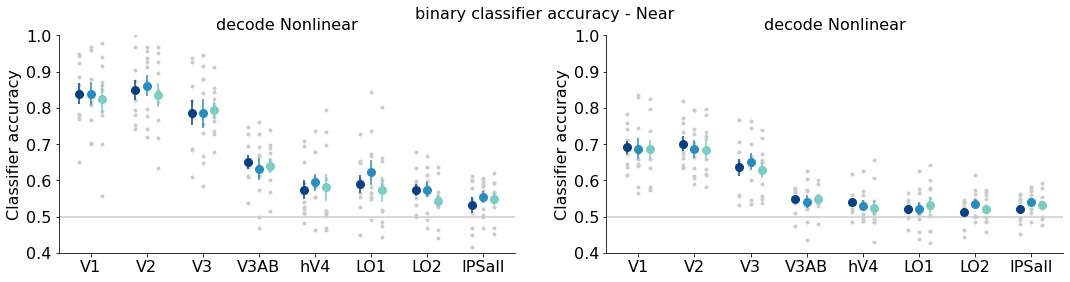

In [9]:
ti_plot = [0,1,2]

x_jitter = np.linspace(-0.2, 0.2, 3)

ii = 0;
axis_name = 'Nonlinear'
    
    
plt.figure(figsize=(18,4))
     
for xx, [avals, name] in enumerate(zip([acc_fartrials, acc_midtrials], \
                     ['Far','Near'])):
    
    
    # rvals = rvals[0:7]

    
    # for ii, axis_name in zip([2], ['axis 3 (nonlin']):

    ax = plt.subplot(1,2,xx+1)

    plt.axhline(1/2, color=[0.8, 0.8, 0.8])

    lh = []

    for ti in ti_plot:

        x_ticks = np.arange(n_rois) + x_jitter[ti]

        vals = avals[:,:,ti,ii]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], markersize=8, zorder=10)
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], \
                         linestyle='none', zorder=10)
        lh.append(h)

    for ri in range(n_rois):

        meanvals = np.mean(avals[:,ri,ti_plot,ii], axis=0)
        # plt.plot(ri+np.array(x_jitter), meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, avals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)

    plt.ylim([0.4, 1.0])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('Classifier accuracy')

    # plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('decode %s'%axis_name)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.suptitle('binary classifier accuracy - %s'%name)
    
figname = os.path.join(figfolder, 'binary_acc_nonlinear.pdf')
print(figname)
plt.savefig(figname)
# 


In [12]:
np.min(acc_fartrials), np.max(acc_fartrials)

(0.4157303370786517, 1.0)

In [13]:
np.min(acc_midtrials), np.max(acc_midtrials)

(0.4266666666666667, 0.8353909465020576)

In [22]:
acc_fartrials.shape

(10, 8, 3, 1)

In [23]:
for avals, diffname in zip([acc_fartrials, acc_midtrials], \
                        ['Far','Near']):

    # for ii, axis_name in enumerate(['axis1','axis2']):

    vals = copy.deepcopy(avals[:,:,:,0])

    anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], \
                                            # do_shuffle=False)
                                            do_shuffle=True, n_iter=10000, rndseed = 243434+ii)


    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'decodebinary_binary_acc_rm_anova_nonlinear_%s.csv'%(diffname))

    print(tablename)
    anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_nonlinear_Far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_nonlinear_Near.csv


In [15]:
for diffname in ['Far','Near']:

    tablename = os.path.join(figfolder, 'decodebinary_binary_acc_rm_anova_nonlinear_%s.csv'%(diffname))
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for %s accuracy, %s trials'%(axis_name, diffname))
    print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_nonlinear_Far.csv
Fri Dec 13 15:03:56 2024

Anova for Nonlinear accuracy, Far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       59.443532     7.0    63.0  0.0000           0.0000
Task       1.012193     2.0    18.0  0.3832           0.3803
ROI:Task   0.658918    14.0   126.0  0.8100           0.8043
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_acc_rm_anova_nonlinear_Near.csv
Fri Dec 13 15:09:44 2024

Anova for Nonlinear accuracy, Near trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       45.988145     7.0    63.0  0.0000           0.0000
Task       0.194981     2.0    18.0  0.8246           0.8289
ROI:Task   0.773928    14.0   126.0  0.6954           0.6956
